In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc, PrecisionRecallDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
filename_path = "C:/Users/tonbo/Documents/ZriveDS/zrive-ds/src/"
df = pd.read_csv(f"{filename_path}feature_frame.csv")

In [4]:
label_col = ["outcome"]
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
feature_cols = [i for i in df.columns if i not in info_cols + label_col]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [i for i in feature_cols if i not in categorical_cols + binary_cols]

In [5]:
# Select only purchases with 5 or more items
def select_relevant_dfs(df: pd.DataFrame):
    order_size = df.groupby("order_id").outcome.sum()
    order_size_greater_index = order_size[order_size >= 5].index
    
    return df.loc[lambda x: x.order_id.isin(order_size_greater_index)]

In [6]:
final_df = select_relevant_dfs(df)

In [7]:
# Modify created at and order_date
final_df["created_at"] = pd.to_datetime(final_df["created_at"])
final_df["order_date"] = pd.to_datetime(final_df["order_date"]).dt.date

C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\3548399307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["created_at"] = pd.to_datetime(final_df["created_at"])
C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\3548399307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["order_date"] = pd.to_datetime(final_df["order_date"]).dt.date


Text(0.5, 1.0, 'Orders per day')

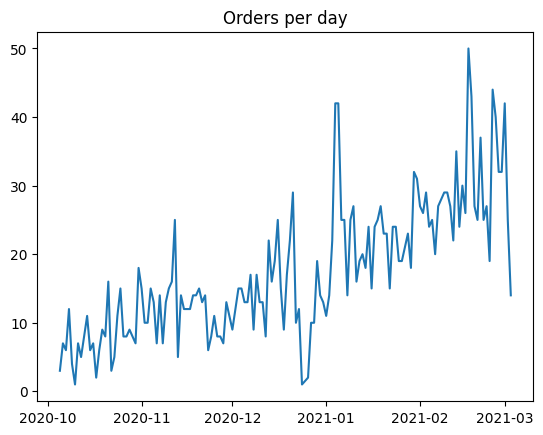

In [8]:
orders_per_day = final_df.groupby("order_date").order_id.nunique()
plt.plot(orders_per_day, label="Orders per day")
plt.title("Orders per day")

In [9]:
# We want to split the dataframe in 3, however we dont want to split the same orders, we need to group by orders_id and later do the split and we want to do a temporal split

cumsum_orders = orders_per_day.cumsum() / orders_per_day.sum()

max_index_train = cumsum_orders[cumsum_orders <= 0.7].idxmax()
max_index_val = cumsum_orders[cumsum_orders <= 0.8].idxmax()
max_index_test = cumsum_orders.idxmax()

In [10]:
train_df = final_df.loc[(final_df["order_date"] >= cumsum_orders.idxmin()) & (final_df["order_date"] <= max_index_train)]
val_df = final_df.loc[(final_df["order_date"] > max_index_train) & (final_df["order_date"] <= max_index_val)]
test_df = final_df.loc[(final_df["order_date"] > max_index_val) & (final_df["order_date"] <= max_index_test)]

In [11]:
train_categorical_df = train_df[numerical_cols + binary_cols + categorical_cols + label_col]
val_categorical_df = val_df[numerical_cols + binary_cols + categorical_cols + label_col]
test_categorical_df = test_df[numerical_cols + binary_cols + categorical_cols + label_col]

In [12]:
train_df = train_df[numerical_cols + binary_cols + label_col]
val_df = val_df[numerical_cols + binary_cols + label_col]
test_df = test_df[numerical_cols + binary_cols + label_col]

In [13]:
train_X = train_df.drop(columns=label_col)
train_y = train_df[label_col]
val_X = val_df.drop(columns=label_col)
val_y = val_df[label_col]

Once we have the train/val/test splits we review how the linear models work

In [20]:
def plot_metrics(y_true: pd.Series, y_pred: pd.Series, figure:tuple[matplotlib.figure.Figure, np.array] = None, lgd_msg: str = "", model: str = "", c_message: str = ""):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_score = auc(recall, precision)

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    if not figure:
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    else:
        fig, ax = figure

    ax[0].plot(recall, precision, label=f"{model}{c_message}AUC={auc_score:.4f}; {lgd_msg}")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"{model}{c_message}AUC={roc_auc:.4f}; {lgd_msg}")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    ax[1].legend()

First of all we need to create a baseline non-ML model to compare with our ML models

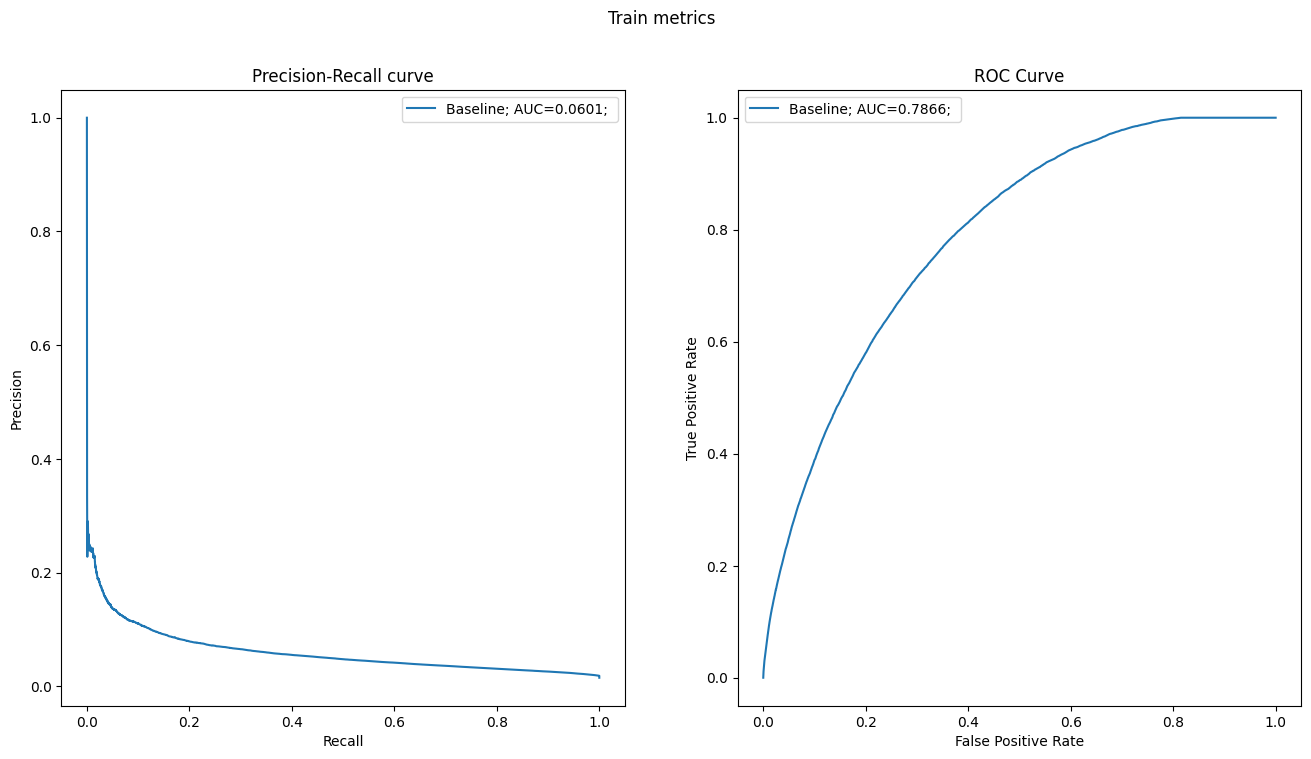

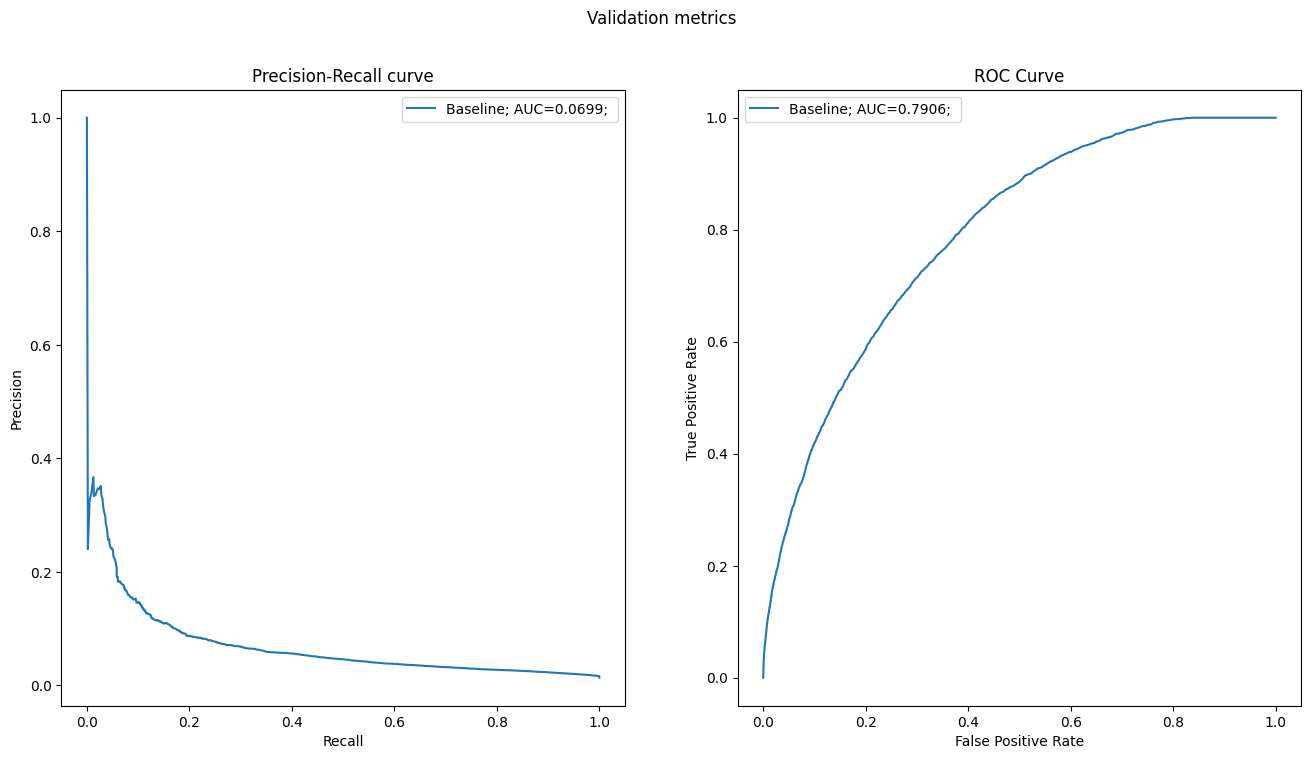

In [22]:
# Baseline will be global popularity column
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train metrics")
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation metrics")

train_y_pred = train_X["global_popularity"]
val_y_pred = val_X["global_popularity"]
plot_metrics(train_y, train_y_pred, (fig1, axs1), model="Baseline; ")
plot_metrics(val_y, val_y_pred, (fig2, axs2), model="Baseline; ")

Creating baseline model
Creating model for C = 1, index 1
Creating model for C = 0.1, index 2
Creating model for C = 0.01, index 3
Creating model for C = 0.001, index 4
Creating model for C = 0.0001, index 5
Creating model for C = 10, index 6


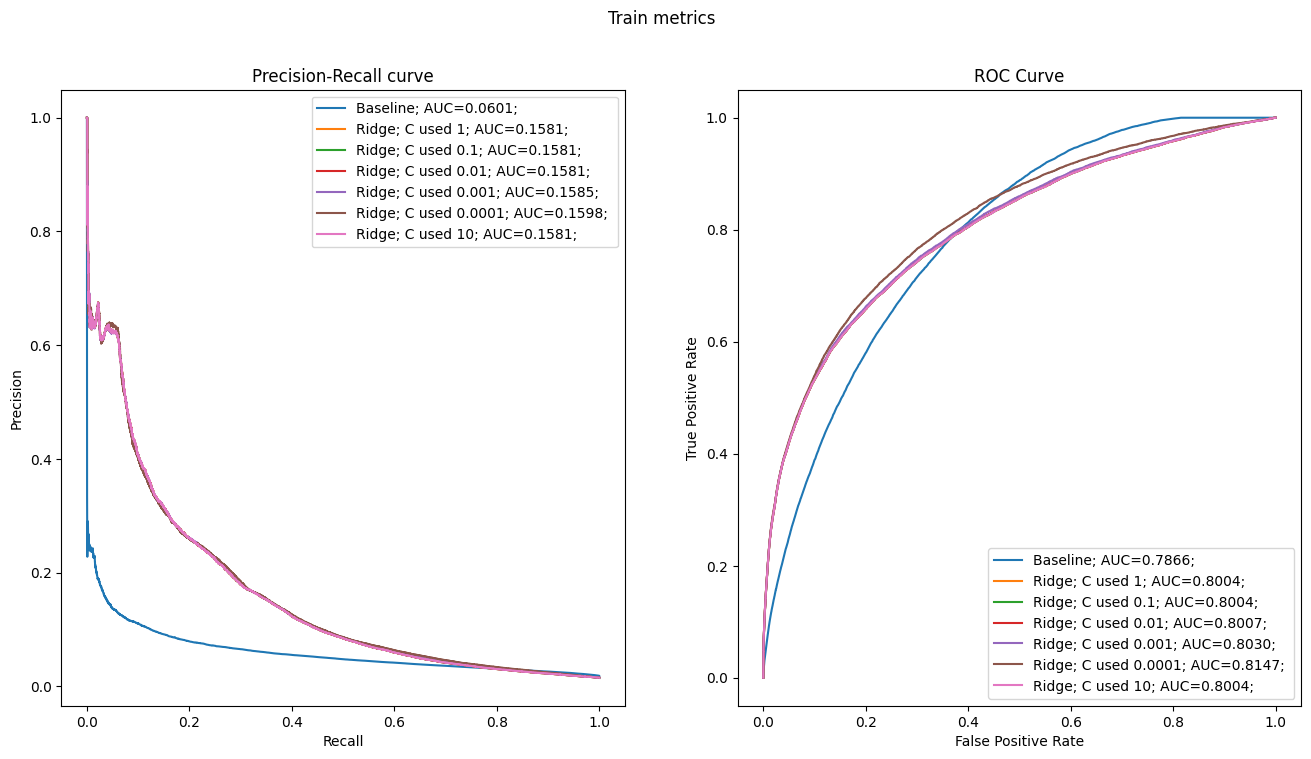

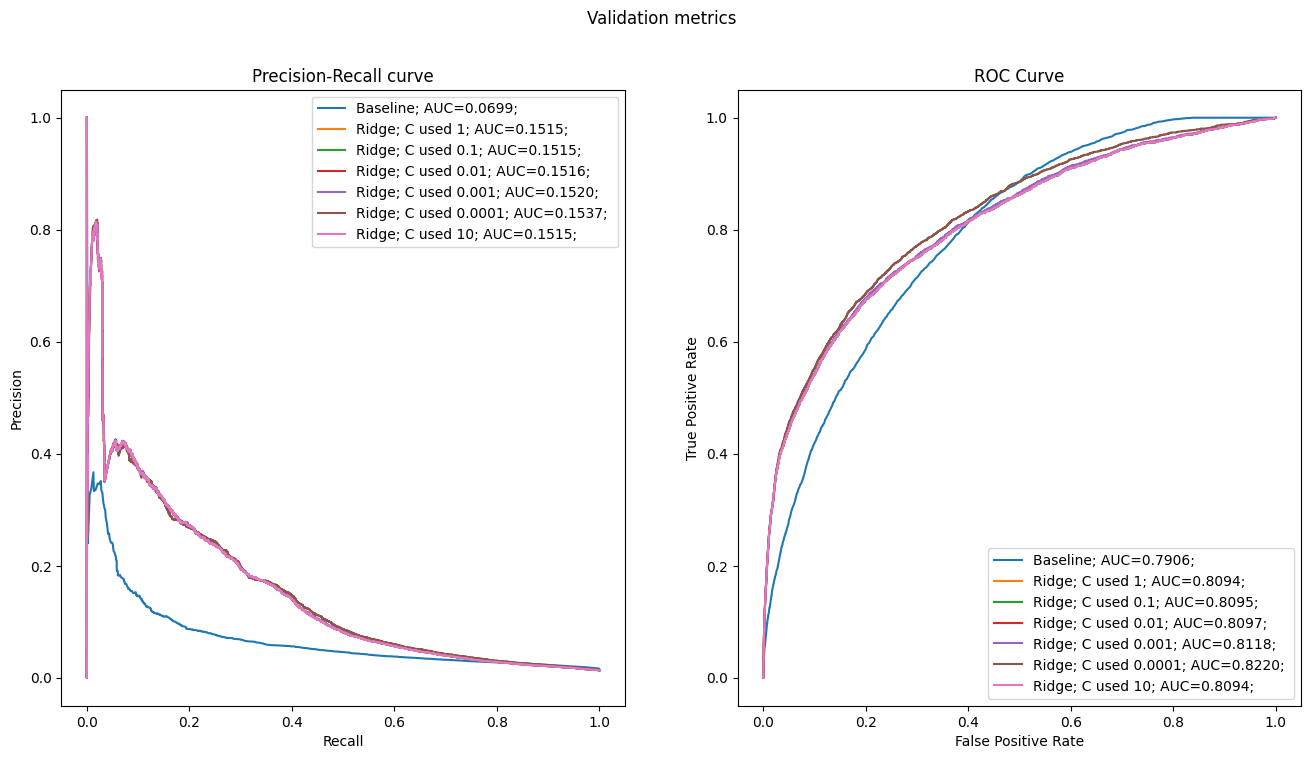

In [25]:
cs = ["baseline", 1, 0.1, 1e-2, 1e-3, 1e-4, 10]
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train metrics")
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation metrics")


for index, c in enumerate(cs):
    if c == "baseline":
        print("Creating baseline model")
        train_y_pred = train_X["global_popularity"]
        val_y_pred = val_X["global_popularity"]
        plot_metrics(train_y, train_y_pred, (fig1, axs1), model="Baseline; ")
        plot_metrics(val_y, val_y_pred, (fig2, axs2), model="Baseline; ")
    else:
        print(f"Creating model for C = {c}, index {index}")
        pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=c, solver="saga"))
        pipe.fit(train_X, train_y.values.ravel())
        train_y_pred = pipe.predict_proba(train_X)[:, 1]
        val_y_pred = pipe.predict_proba(val_X)[:, 1]
        plot_metrics(train_y, train_y_pred, (fig1, axs1), model="Ridge; ", c_message=f"C used {c}; ")
        plot_metrics(val_y, val_y_pred, (fig2, axs2), model="Ridge; ", c_message=f"C used {c}; ")

Creating baseline model
Creating model for C = 1, index 1
Creating model for C = 0.1, index 2
Creating model for C = 0.01, index 3
Creating model for C = 0.001, index 4
Creating model for C = 0.0001, index 5
Creating model for C = 10, index 6


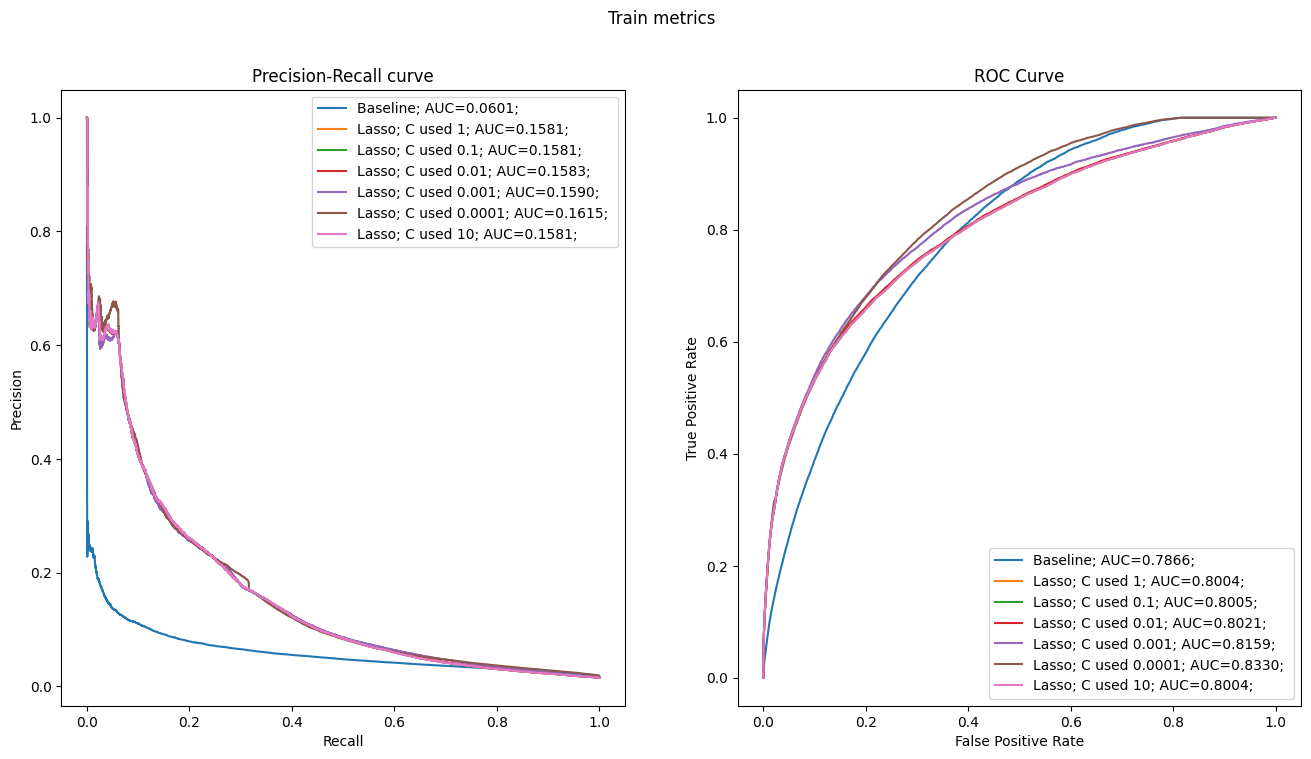

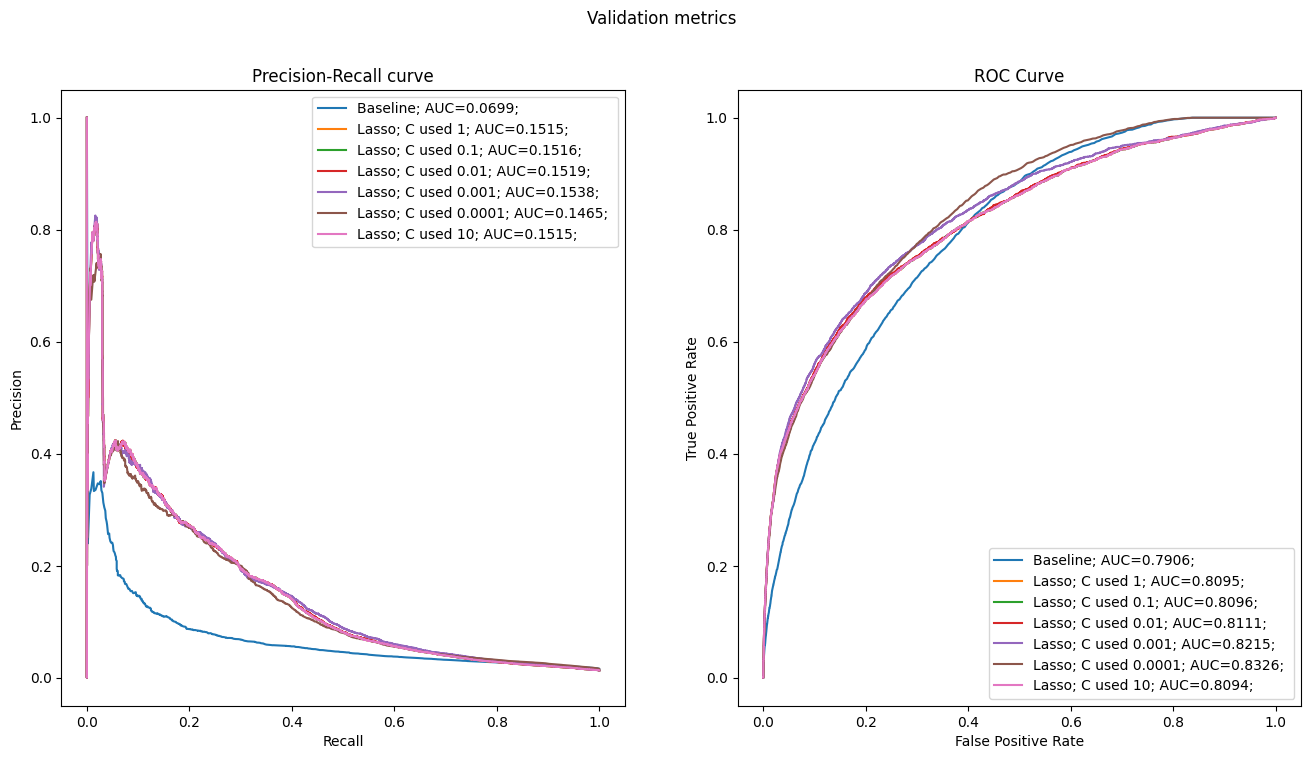

In [26]:
cs = ["baseline", 1, 0.1, 1e-2, 1e-3, 1e-4, 10]
fig1, axs1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train metrics")
fig2, axs2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation metrics")


for index, c in enumerate(cs):
    if c == "baseline":
        print("Creating baseline model")
        train_y_pred = train_X["global_popularity"]
        val_y_pred = val_X["global_popularity"]
        plot_metrics(train_y, train_y_pred, (fig1, axs1), model="Baseline; ")
        plot_metrics(val_y, val_y_pred, (fig2, axs2), model="Baseline; ")
    else:
        print(f"Creating model for C = {c}, index {index}")
        pipe = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', C=c, solver="saga"))
        pipe.fit(train_X, train_y.values.ravel())
        train_y_pred = pipe.predict_proba(train_X)[:, 1]
        val_y_pred = pipe.predict_proba(val_X)[:, 1]
        plot_metrics(train_y, train_y_pred, (fig1, axs1), model="Lasso; ", c_message=f"C used {c}; ")
        plot_metrics(val_y, val_y_pred, (fig2, axs2), model="Lasso; ", c_message=f"C used {c}; ")

Once seen that the Linear models are better than our baseline we will explore with non-linear models

Creating RandomForest model with 5 trees


C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\810236553.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X, train_y)


Creating RandomForest model with 25 trees


C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\810236553.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X, train_y)


Creating RandomForest model with 50 trees


C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\810236553.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X, train_y)


Creating RandomForest model with 100 trees


C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\810236553.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X, train_y)


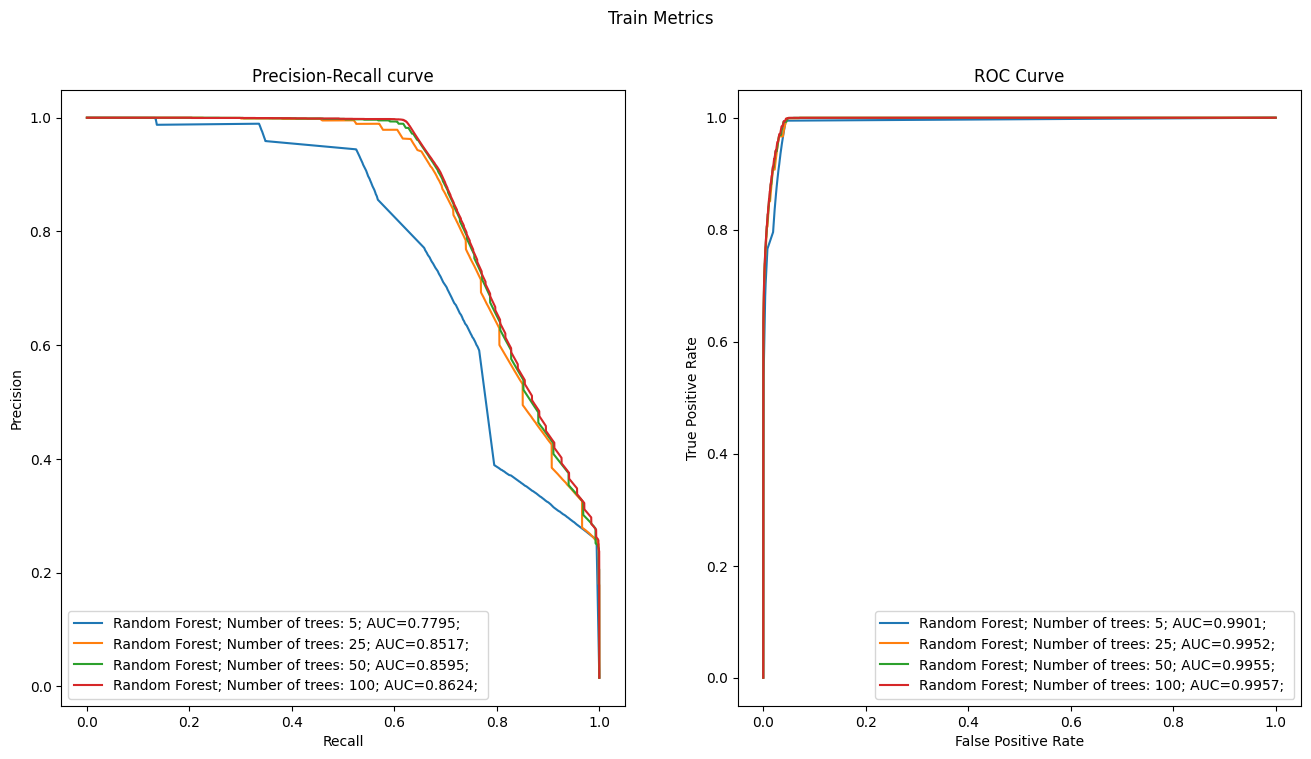

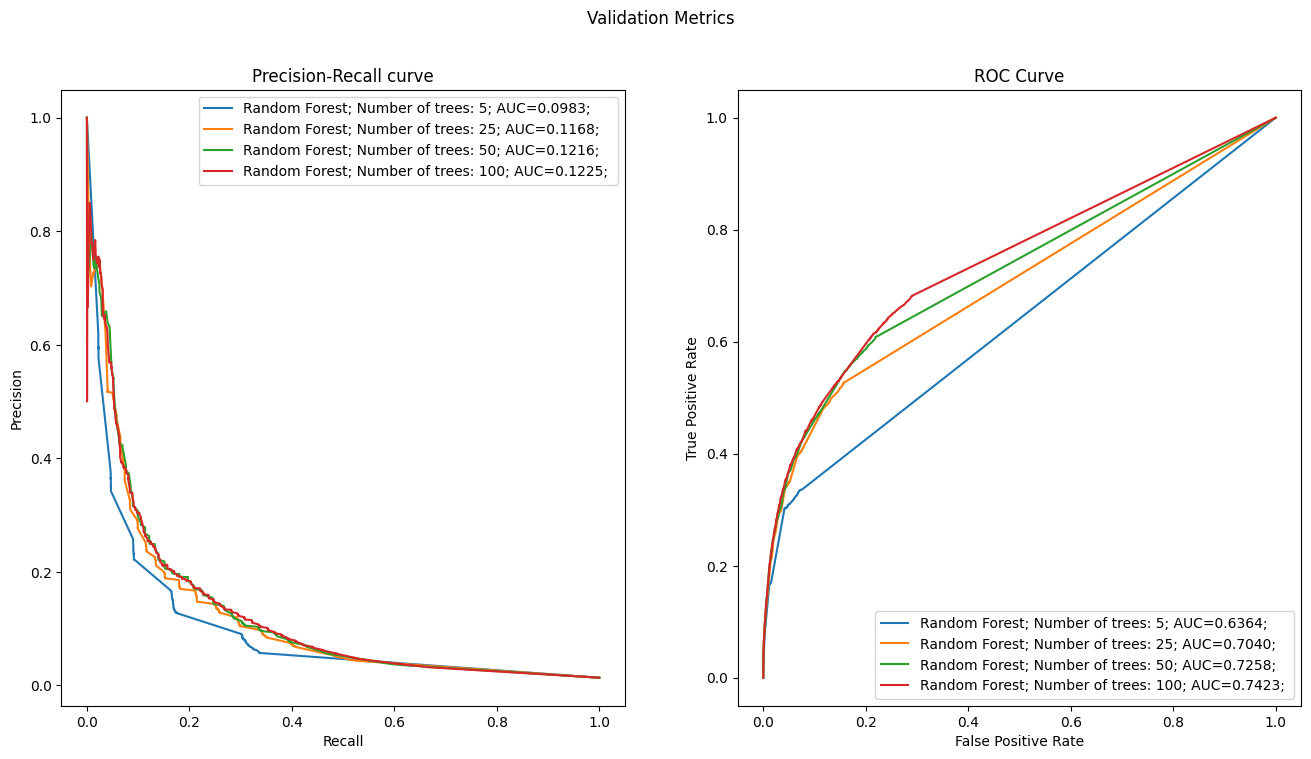

In [35]:
# Lets go directly with the RandomForest
n_trees = [5, 25, 50, 100]
fig1, ax1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train Metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation Metrics")

for n in n_trees:
    print(f"Creating RandomForest model with {n} trees")
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(train_X, train_y)
    train_pred = rf.predict_proba(train_X)[:, 1]
    val_pred = rf.predict_proba(val_X)[:, 1]

    plot_metrics(train_y, train_pred, (fig1, ax1), model="Random Forest; ", c_message=f"Number of trees: {n}; ")
    plot_metrics(val_y, val_pred, (fig2, ax2), model="Random Forest; ", c_message=f"Number of trees: {n}; ")

In [37]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_X, train_y)

C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\3333715738.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_X, train_y)


RandomForestClassifier()

<AxesSubplot:xlabel='importance', ylabel='features'>

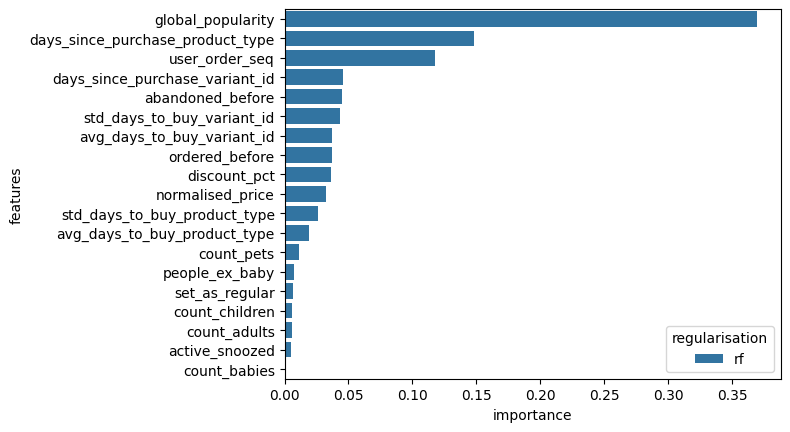

In [42]:
pipe_coeffs_rf = pd.DataFrame({"features": numerical_cols + binary_cols, "importance": np.abs(rf.feature_importances_), "regularisation": ["rf"]*len(numerical_cols + binary_cols)})
pipe_coeffs_rf.sort_values("importance", ascending=True)
order_columns = pipe_coeffs_rf.sort_values("importance", ascending=False)["features"]
sns.barplot(pipe_coeffs_rf, x="importance", y="features", hue="regularisation", order=order_columns)

C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\2496522120.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  important_columns = order_columns[:15]


Creating RandomForest model with 100 trees


C:\Users\tonbo\AppData\Local\Temp\ipykernel_22540\2496522120.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(reduced_cols_train_X, train_y)


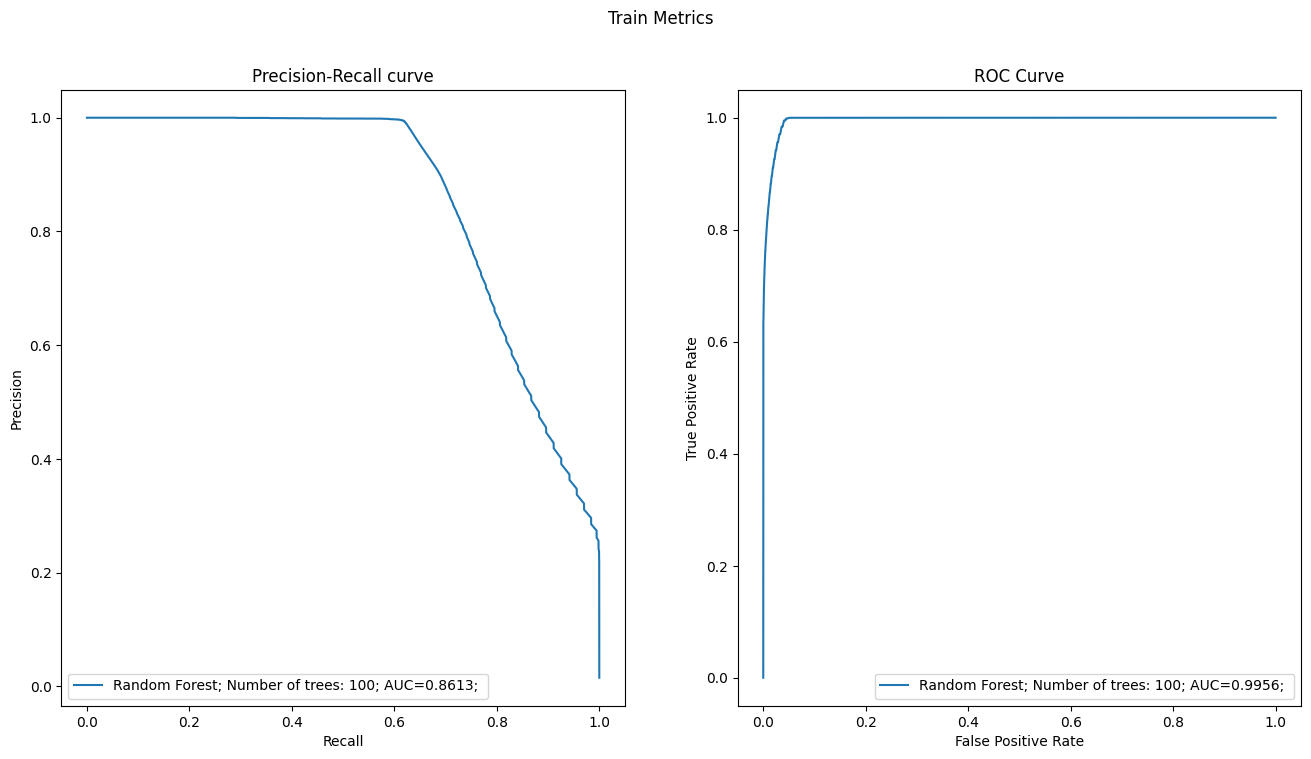

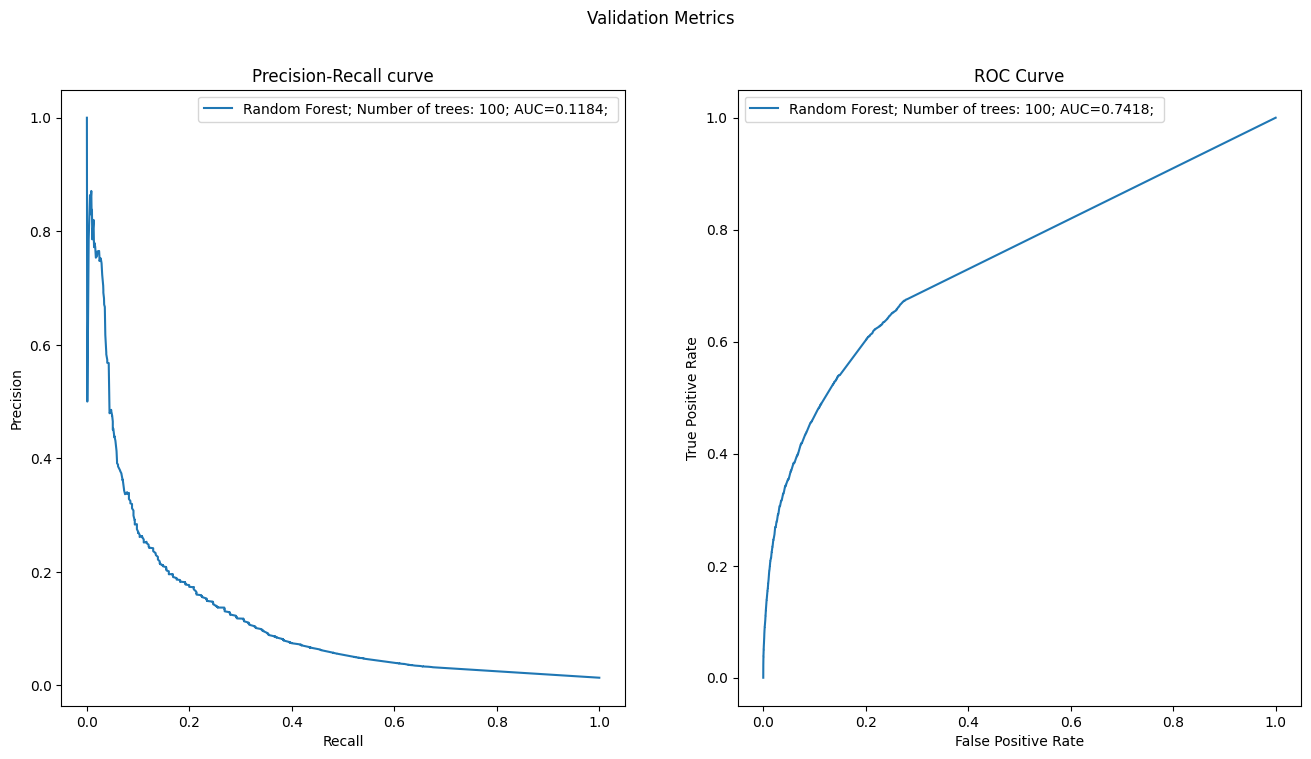

In [47]:
important_columns = order_columns[:15]
reduced_cols_train_X = train_X[important_columns]
reduced_cols_val_X = val_X[important_columns]

n_trees = [5, 25, 50, 100]
fig1, ax1 = plt.subplots(1, 2, figsize=(16, 8))
fig1.suptitle("Train Metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(16, 8))
fig2.suptitle("Validation Metrics")

n = 100
print(f"Creating RandomForest model with {n} trees")
rf = RandomForestClassifier(n_estimators=n)
rf.fit(reduced_cols_train_X, train_y)
train_pred = rf.predict_proba(reduced_cols_train_X)[:, 1]
val_pred = rf.predict_proba(reduced_cols_val_X)[:, 1]

plot_metrics(train_y, train_pred, (fig1, ax1), model="Random Forest; ", c_message=f"Number of trees: {n}; ")
plot_metrics(val_y, val_pred, (fig2, ax2), model="Random Forest; ", c_message=f"Number of trees: {n}; ")

In [ ]:
#TODO: Gradient Descent Forest